In [167]:
import sys
sys.path.append("/tf/ProjectGabriel/pilca")

In [168]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from lightcurve_fitting import models, filters, lightcurve
import matplotlib.pyplot as plt
import matplotlib as mpl
import importlib



from utils.utils import load_lc
from utils.utils import light_curve_plot
import torch
import utils.torchphysics as tp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
torch.set_default_dtype(torch.float64)


# Building Fake Light Curve

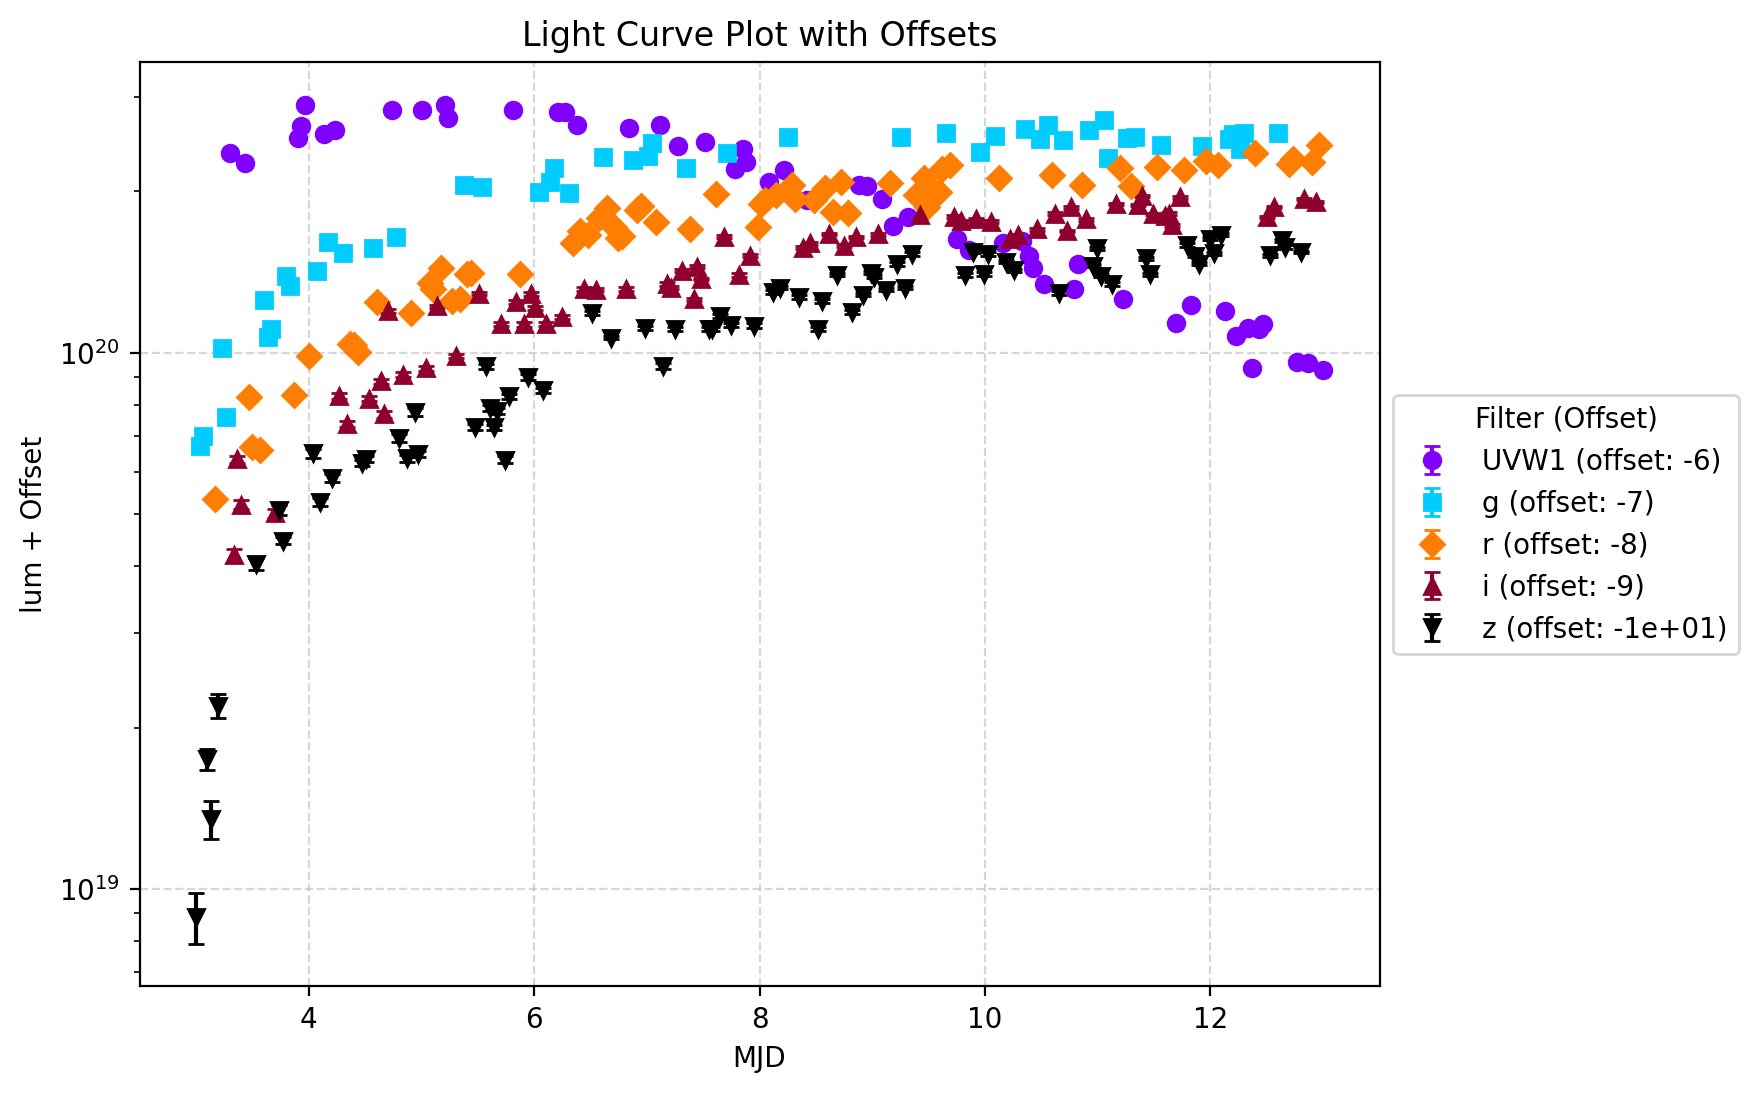

In [ ]:
importlib.reload(models)
lc_fake = load_lc(fake=True)
model = models.ShockCooling4(lc_fake)


MJD = np.linspace(3, 13, 300)
filters_list = [filters.filtdict["g"],filters.filtdict["uvw1"], filters.filtdict["r"], filters.filtdict["i"], filters.filtdict["z"]]
filter_for_mjd = np.random.choice(filters_list, size=len(MJD), replace=True)

ten13cmtoRsol = 1e13*1.4374e-11
ten8p5cmstoten3kms = 10**.5
units_array = np.array([ten8p5cmstoten3kms, 1, 1, ten13cmtoRsol, 1])
# model_inputs = np.array([7.2, 5, 1.6, 410, 2.5])/units_array
model_inputs = np.array([4, 2, 580, 2.5])/units_array

v_s = model_inputs[0]       # Shock velocity
M_env = model_inputs[1]     # Envelope mass
f_rho_M = model_inputs[1]   # Density profile factor
R = model_inputs[3]         # Radius
t_exp = model_inputs[4]     # explosion time
lum = model(MJD, v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=filter_for_mjd) + np.random.normal(0, 1e19, len(MJD))

lc = load_lc(lc=lightcurve.LC({"MJD":MJD,
                "lum":lum,
                "dlum":np.random.normal(.1e19, .1e18, len(lum)),
                "filter":filter_for_mjd}),
                fake=False)
lc
light_curve_plot(lc, offset = 1)

# Preparing PILCA

In [124]:
MJD_TO_MODEL = MJD
LUM_TO_MODEL = np.log10(lc["lum"])
DLUM_TO_MODEL = lc["dlum"]/lc["lum"]/np.log(10)

X_DATA = np.hstack([MJD_TO_MODEL.reshape(-1,1), LUM_TO_MODEL.reshape(-1,1), DLUM_TO_MODEL.reshape(-1,1)])
ufilters = np.unique(lc["filter"])
filters_mask = torch.zeros((len(ufilters),len(lc)), requires_grad=False, dtype=torch.bool)
for i in range(len(ufilters)):
    filters_mask[i] = torch.tensor(lc["filter"]==ufilters[i])

X_DATA = torch.tensor(X_DATA, requires_grad=False)

In [125]:
filters_mask[0]

tensor([False, False, False, False, False, False, False, False, False,  True,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,  True,
        False, False, False, False,  True, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
         True, False, False, False, False, False,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False,  True, False,  True, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False,  True, False, False, False, False, 

In [126]:
importlib.reload(models)
lc_fake = load_lc(fake=True)
model_original = models.ShockCooling4(lc_fake)

ten13cmtoRsol = 1e13*1.4374e-11

ten8p5cmstoten3kms = 10**.5
units_array = np.array([ten8p5cmstoten3kms, 1, 1, ten13cmtoRsol, 1])
# model_inputs = #np.array([5.3875e+00, 4.1513e-07, 2.6636e+00, 1.7901e+00, 8.9253e-01])
v_s = model_inputs[0]       # Shock velocity
M_env = model_inputs[1]     # Envelope mass
f_rho_M = model_inputs[2]   # Density profile factor
R = model_inputs[3]         # Radius
t_exp = model_inputs[4]     # explosion time

lum = model_original(MJD[0:], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=[filter_for_mjd[0]])
lum_original = lum
lum[:20]

array([[2.33284398e+19, 2.43563796e+19, 2.53782369e+19, 2.63938229e+19,
        2.74029920e+19, 2.84056332e+19, 2.94016639e+19, 3.03910249e+19,
        3.13736758e+19, 3.23495923e+19, 3.33187632e+19, 3.42811882e+19,
        3.52368762e+19, 3.61858441e+19, 3.71281148e+19, 3.80637169e+19,
        3.89926835e+19, 3.99150515e+19, 4.08308611e+19, 4.17401548e+19,
        4.26429778e+19, 4.35393768e+19, 4.44294000e+19, 4.53130968e+19,
        4.61905178e+19, 4.70617141e+19, 4.79267374e+19, 4.87856399e+19,
        4.96384739e+19, 5.04852921e+19, 5.13261471e+19, 5.21610914e+19,
        5.29901775e+19, 5.38134578e+19, 5.46309842e+19, 5.54428086e+19,
        5.62489825e+19, 5.70495569e+19, 5.78445826e+19, 5.86341097e+19,
        5.94181883e+19, 6.01968677e+19, 6.09701967e+19, 6.17382239e+19,
        6.25009972e+19, 6.32585640e+19, 6.40109712e+19, 6.47582653e+19,
        6.55004921e+19, 6.62376971e+19, 6.69699250e+19, 6.76972203e+19,
        6.84196267e+19, 6.91371875e+19, 6.98499455e+19, 7.055794

In [127]:
importlib.reload(tp)
model_inputs_torch = torch.tensor(model_inputs)#torch.tensor([5.3875e+00, 4.1513e-07, 2.6636e+00, 1.7901e+00, 8.9253e-01], dtype=torch.float64)


v_s = model_inputs_torch[0]       # Shock velocity
M_env = model_inputs_torch[1]     # Envelope mass
f_rho_M = model_inputs_torch[2]   # Density profile factor
R = model_inputs_torch[3]         # Radius
t_exp = model_inputs_torch[4]     # explosion time
model_torch = tp.ShockCooling4(z=lc.meta["redshift"])
lum= model_torch(MJD[:], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=filter_for_mjd[0])
lum_torch = lum
lum#[:20]

tensor([2.3328e+19, 2.4356e+19, 2.5378e+19, 2.6394e+19, 2.7403e+19, 2.8406e+19,
        2.9402e+19, 3.0391e+19, 3.1374e+19, 3.2350e+19, 3.3319e+19, 3.4281e+19,
        3.5237e+19, 3.6186e+19, 3.7128e+19, 3.8064e+19, 3.8993e+19, 3.9915e+19,
        4.0831e+19, 4.1740e+19, 4.2643e+19, 4.3539e+19, 4.4429e+19, 4.5313e+19,
        4.6191e+19, 4.7062e+19, 4.7927e+19, 4.8786e+19, 4.9638e+19, 5.0485e+19,
        5.1326e+19, 5.2161e+19, 5.2990e+19, 5.3813e+19, 5.4631e+19, 5.5443e+19,
        5.6249e+19, 5.7050e+19, 5.7845e+19, 5.8634e+19, 5.9418e+19, 6.0197e+19,
        6.0970e+19, 6.1738e+19, 6.2501e+19, 6.3259e+19, 6.4011e+19, 6.4758e+19,
        6.5500e+19, 6.6238e+19, 6.6970e+19, 6.7697e+19, 6.8420e+19, 6.9137e+19,
        6.9850e+19, 7.0558e+19, 7.1261e+19, 7.1960e+19, 7.2654e+19, 7.3343e+19,
        7.4028e+19, 7.4708e+19, 7.5384e+19, 7.6055e+19, 7.6722e+19, 7.7385e+19,
        7.8043e+19, 7.8697e+19, 7.9347e+19, 7.9993e+19, 8.0634e+19, 8.1271e+19,
        8.1904e+19, 8.2533e+19, 8.3158e+

In [128]:
torch.sqrt(torch.sum((torch.tensor(lum_original) - lum_torch)**2))/len(lum_original)/(torch.tensor(lum_original)).mean()


tensor(4.0942e-15)

In [164]:
model_inputs_torch = outputs.detach()#torch.tensor(model_inputs)#/units_array

v_s = model_inputs_torch[0]       # Shock velocity
M_env = model_inputs_torch[1]     # Envelope mass
f_rho_M = model_inputs_torch[1]   # Density profile factor
R = model_inputs_torch[3]         # Radius
t_exp = model_inputs_torch[4]     # explosion time
model = tp.ShockCooling4(z=lc.meta["redshift"])
for f in np.unique(filter_for_mjd):
    mask = filter_for_mjd == f
    y = model(MJD[mask], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=f)
    print(y)

##################################


tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0588e+20, 2.5030e+20, 2.7180e+20, 2.7464e+20, 3.0076e+20,
        3.0302e+20, 3.0260e+20, 3.0163e+20, 2.9311e+20, 2.7982e+20, 2.6779e+20,
        2.5163e+20, 2.3419e+20, 2.3000e+20, 2.2793e+20, 2.1590e+20, 2.0823e+20,
        1.9723e+20, 1.7384e+20, 1.7075e+20, 1.6474e+20, 1.6038e+20, 1.5476e+20,
        1.3794e+20, 1.3435e+20, 1.2419e+20, 1.1892e+20, 1.1688e+20, 1.1588e+20,
        1.1292e+20, 1.0545e+20, 1.0456e+20, 9.4474e+19, 8.4078e+19, 8.1352e+19,
        7.5579e+19, 7.3760e+19, 7.1991e+19, 7.1412e+19, 7.0270e+19, 6.9707e+19,
        6.4866e+19, 6.3338e+19, 6.1366e+19])
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7084e+19,
        6.7505e+19, 9.7099e+19, 1.6493e+20, 1.7949e+20, 2.1502e+20, 2.2089e+20,
        2.2277e+20, 2.2990e+20, 2.4392e+20, 2.5433e+20, 2.5889e+20, 2.5997e

In [165]:
importlib.reload(tp)
model = tp.ShockCooling4(z=lc.meta["redshift"])

pilcas = []
# fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

for i, f in enumerate(np.unique(filter_for_mjd)):
    mask = filter_for_mjd == f
    print(np.sum(mask), np.sum(lc["filter"]==f), np.sum(filters_mask.detach().numpy()[i]))
    y = model(MJD[mask], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=f)
    # print(len(y), np.sum(mask))
    # ax.plot(MJD[mask], y)
    pilcas.append(y)
len(MJD), len(lc["MJD"]), np.sum(np.array(lc["filter"])==np.unique(filter_for_mjd)[0])

51 51 51
47 47 47
66 66 66
64 64 64
72 72 72


(300, 300, 51)

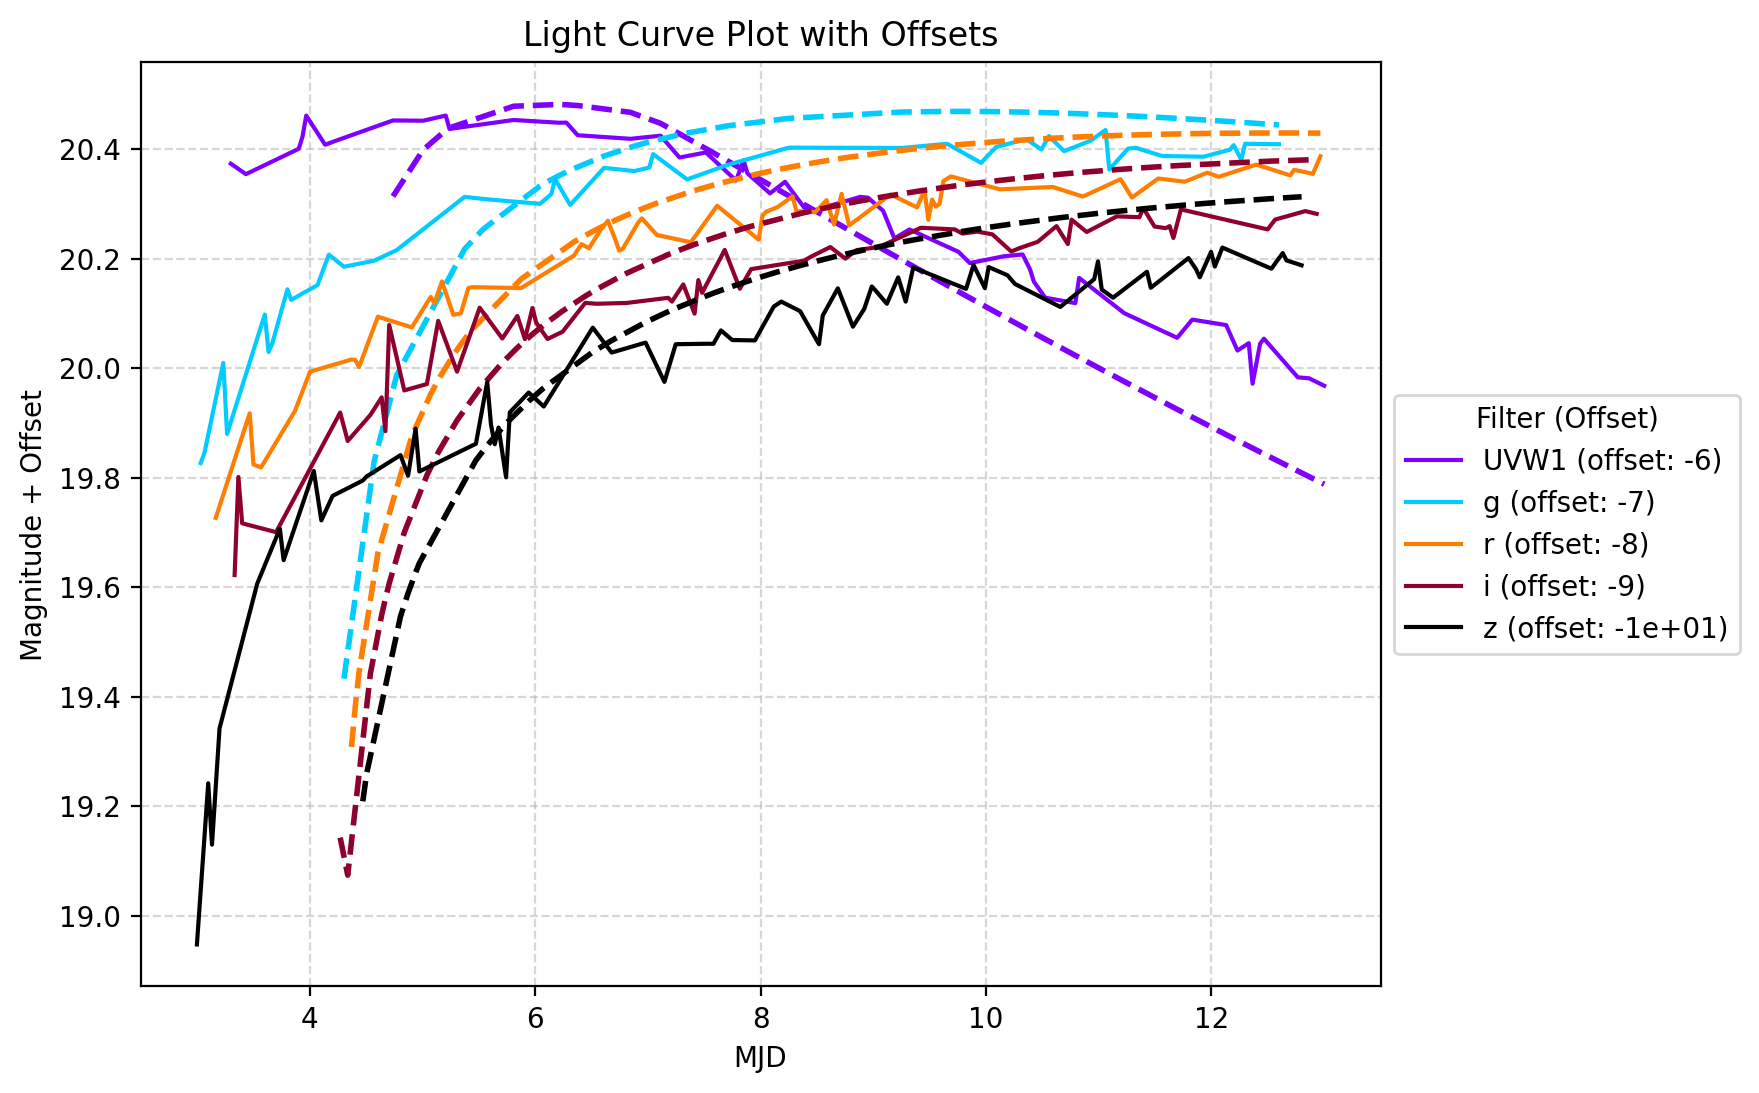

In [166]:

def pilca_light_curve_plot(lc, offset=0.5, pilcas=None, ufilters=None):
    """
    Plots light curves with different markers, applying an offset for each filter.
    
    Parameters:
    lc : dict or structured array
        A dataset containing 'MJD', 'mag', 'dmag', and 'filter' fields.
    """

    # Unique filters in the dataset
    ufilts = ufilters#np.unique(lc['filter'])

    # Define marker styles for each filter
    markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']
    face_color = []
    
    # Define offsets for each filter (spaced by 0.5 mag)
    offsets = {filt: -10 + i * offset for i, filt in enumerate(ufilts[::-1])}

    fig, ax = plt.subplots(figsize=(8, 6), dpi=200)  # Set figure size

    for i, filt in enumerate(ufilts):
        # Create mask for the current filter
        fmask = np.array(lc['filter'] == filt)
        
        # Extract values and apply offset
        mjd_filt = lc['MJD'][fmask]
        y_filt = lc['lum'][fmask] + offsets[filt]  # Apply offset
        y_filt_err = lc['dlum'][fmask]
        if pilcas:
            y_pilca = pilcas[i]
        # Select marker style based on index
        marker = markers[i % len(markers)]
        
        style = filt.plotstyle

        # Plot with error bars
        # ax.errorbar(mjd_filt, y_filt, yerr=y_filt_err,
        #  fmt=marker, label=f"{filt} (offset: {offsets[filt]:.1g})",
        #  capsize=3, **style)
        ax.plot(mjd_filt, np.log10(y_filt), 
         ls="-", label=f"{filt} (offset: {offsets[filt]:.1g})", **style)
        # print(filt)
        # aaa
        ax.plot(mjd_filt, torch.log10(y_pilca), c=style["mfc"], lw=2, ls="--")

    # Aesthetics
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude + Offset")
    # ax.invert_yaxis()  # Invert y-axis for magnitudes
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title("Light Curve Plot with Offsets")
    # ax.set_yscale("log")
    # Move the legend to the right of the plot
    ax.legend(title="Filter (Offset)", loc='center left', bbox_to_anchor=(1, 0.5))

        
# light_curve_plot(lc)
pilca_light_curve_plot(lc, offset = 1, pilcas=pilcas, ufilters=np.unique(filter_for_mjd))

# BNN

In [158]:
importlib.reload(tp)

bnn = tp.MultiFilterBNN(x_data=X_DATA,
                    filters_mask=filters_mask,
                    param_dim=5,
                    hidden_dim=32)

# model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
lr=1e-3
optimizer = torch.optim.Adam(bnn.parameters(), lr=lr)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.SC4Loss(sc4model, ufilters=ufilters)
epochs = 2000
n_samples_loss = 100

def hard_loss(y_pred, y_true):

    return torch.mean((y_pred - y_true)**2)

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = bnn()+1e-5#.get_params()
    # outputs = tp.get_physical(outputs, b=1e-3, low=0, high=10)
    # outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    # print(outputs)
    # aaa
    loss = criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss

    # for i in range(n_samples_loss-1):
    #     outputs = flow.sample(1)
    #     # print(outputs)
    #     outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    #     loss += criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss
    #     print(loss)
    #     # aa

    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        # with torch.no_grad():
        tp.print_outputs(outputs.squeeze(), loss, epoch)
        # print(outputs)
        # print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


--- Step 0 ---
Shock velocity (v_s):     1.9518
Envelope mass (M_env):    2.6521
Density factor (f_rho_M): 3.4867
Radius (R):               4.3370
Explosion time (t_exp):   4.2286
Loss:                     0.013092
----------------------------------------
--- Step 100 ---
Shock velocity (v_s):     1.2611
Envelope mass (M_env):    1.7262
Density factor (f_rho_M): 1.7383
Radius (R):               2.0397
Explosion time (t_exp):   7.3345
Loss:                     0.002324
----------------------------------------
--- Step 200 ---
Shock velocity (v_s):     1.6479
Envelope mass (M_env):    1.6607
Density factor (f_rho_M): 1.9183
Radius (R):               1.7531
Explosion time (t_exp):   2.9482
Loss:                     0.001833
----------------------------------------
--- Step 300 ---
Shock velocity (v_s):     1.6878
Envelope mass (M_env):    1.7026
Density factor (f_rho_M): 2.9159
Radius (R):               1.8341
Explosion time (t_exp):   4.8808
Loss:                     0.001962
-----------

In [ ]:
true = model_inputs
true


array([1.26491106, 2.        , 0.21      , 4.03506331, 2.5       ])

In [159]:
samples = []
for i in range(1000):
    samples.append(bnn())
samples = torch.stack(samples).detach().cpu().numpy() # shape [N_samples, 5]

print(samples.shape)


(1000, 5)


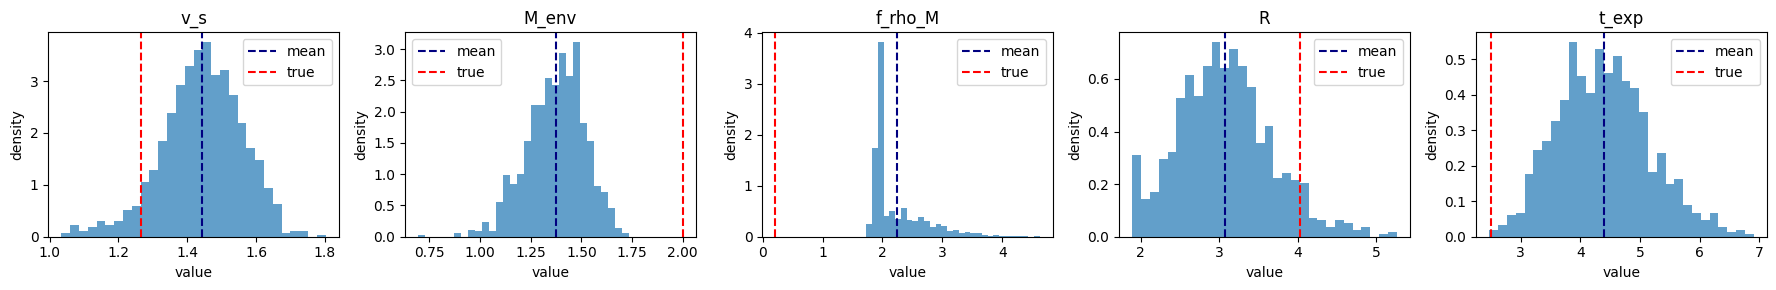

In [160]:

param_names = ["v_s", "M_env", "f_rho_M", "R", "t_exp"]
mean = samples.mean(0)
std = samples.std(0)
true = model_inputs
fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for i, name in enumerate(param_names):
    axes[i].hist(samples[:, i], bins=30, density=True, color="tab:blue", alpha=0.7)
    axes[i].axvline(mean[i], color="navy", linestyle="--", label="mean")
    axes[i].axvline(true[i], color="red", linestyle="--", label="true")

    axes[i].set_title(name)
    axes[i].set_xlabel("value")
    axes[i].set_ylabel("density")
    axes[i].legend()

plt.tight_layout()
plt.show()

# MDN

In [ ]:
X_DATA.shape, filters_mask.shape

(torch.Size([300, 3]), torch.Size([5, 300]))

In [ ]:
importlib.reload(tp)

mdn = tp.MultiFilterMDN(x_data=X_DATA,
                    filters_mask=filters_mask,
                    param_dim=5,
                    num_components=3,
                    hidden_dim=32)

In [ ]:
mdn.get_params()[1].shape


mdn.get_params()



tensor([0.6466, 0.6641, 0.3276, 0.3274, 0.3100], grad_fn=<AddBackward0>)

In [ ]:
importlib.reload(tp)

# model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
lr=1
optimizer = torch.optim.Adam(mdn.parameters(), lr=lr)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.SC4Loss(sc4model, ufilters=ufilters)
epochs = 20
n_samples_loss = 10

def hard_loss(y_pred, y_true):

    return torch.mean((y_pred - y_true)**2)

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = mdn.get_params()
    # outputs = tp.get_physical(outputs, b=1e-3, low=0, high=10)
    # outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    # print(outputs)
    # aaa
    loss = criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss

    # for i in range(n_samples_loss-1):
    #     outputs = flow.sample(1)
    #     # print(outputs)
    #     outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    #     loss += criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss
    #     print(loss)
    #     # aa

    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:
        # with torch.no_grad():
        tp.print_outputs(outputs.squeeze(), loss, epoch)
        # print(outputs)
        # print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


--- Step 0 ---
Shock velocity (v_s):     0.6466
Envelope mass (M_env):    0.6641
Density factor (f_rho_M): 0.3276
Radius (R):               0.3274
Explosion time (t_exp):   0.3100
Loss:                     1.469037
----------------------------------------
--- Step 1 ---
Shock velocity (v_s):     6812113.3737
Envelope mass (M_env):    6498957.2815
Density factor (f_rho_M): 0.0000
Radius (R):               6857056.4321
Explosion time (t_exp):   6761768.8065
Loss:                     inf
----------------------------------------
--- Step 2 ---
Shock velocity (v_s):     nan
Envelope mass (M_env):    nan
Density factor (f_rho_M): nan
Radius (R):               nan
Explosion time (t_exp):   nan
Loss:                     nan
----------------------------------------
--- Step 3 ---
Shock velocity (v_s):     nan
Envelope mass (M_env):    nan
Density factor (f_rho_M): nan
Radius (R):               nan
Explosion time (t_exp):   nan
Loss:                     nan
--------------------------------------

0

In [ ]:
for p in mdn.parameters(): 
    print(p.grad.abs().mean())

tensor(53.5003)
tensor(5.6190)
tensor(42.8264)
tensor(32.3367)
tensor(75.9660)
tensor(8.0848)
tensor(71.6435)
tensor(33.3304)
tensor(197.5081)
tensor(20.9123)
tensor(151.1851)
tensor(45.4060)
tensor(118.1536)
tensor(12.7837)
tensor(72.7717)
tensor(26.9660)
tensor(102.9334)
tensor(11.0119)
tensor(123.0183)
tensor(46.4581)
tensor(231.2423)
tensor(182.9379)
tensor(102.0486)
tensor(178.0926)
tensor(190.6379)
tensor(332.6963)


AttributeError: 'NoneType' object has no attribute 'abs'

# Normalizing Flows

In [ ]:
import torch
from nflows.transforms.base import Transform

class ExpTransform(Transform):
    """Bijetiva: ℝ → (0, ∞)"""
    def _call(self, inputs, context=None):
        return torch.exp(inputs)

    def _inverse(self, outputs, context=None):
        eps = 1e-10
        return torch.log(outputs + eps)

    def _log_det_jacobian(self, inputs, context=None):
        # log|dy/dx| = sum(log(exp(x))) = sum(x)
        return torch.sum(inputs, dim=1)


In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from nflows.flows import Flow
from nflows.transforms import MaskedAffineAutoregressiveTransform
from nflows.distributions import StandardNormal
torch.autograd.set_detect_anomaly(True)
from nflows.transforms import CompositeTransform, Sigmoid, AffineTransform, LeakyReLU, Tanh
from nflows.transforms.base import Transform

p_low, p_high = 0, 10
param_dim = 5
k_layers = 1

layers = []

for i in range(k_layers):
    layers+=[MaskedAffineAutoregressiveTransform(features=param_dim, hidden_features=32),
            # ExpTransform()#LeakyReLU(negative_slope=1e-3)
            # AffineTransform()
            ] 

flow = Flow(
    CompositeTransform(layers),
    StandardNormal([param_dim])
)
flow = flow.double()

In [ ]:
a = flow.sample(1)
a = tp.sigmoid(a, b=1e-3)
a = tp.denormalize(a, low=0, high=10)
a

tensor([[4.9946, 5.0082, 5.0061, 4.9998, 4.9970]], grad_fn=<AddBackward0>)

In [ ]:
importlib.reload(tp)

# model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
lr=1e-1
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.SC4Loss(sc4model, ufilters=ufilters)
epochs = 3000
n_samples_loss = 10

def hard_loss(y_pred, y_true):

    return torch.mean((y_pred - y_true)**2)

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = flow.sample(num_samples=1)
    outputs = tp.get_physical(outputs, b=1e-3, low=0, high=10)
    # outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    # print(outputs)
    # aaa
    loss = criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss

    # for i in range(n_samples_loss-1):
    #     outputs = flow.sample(1)
    #     # print(outputs)
    #     outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    #     loss += criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss
    #     print(loss)
    #     # aa

    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        with torch.no_grad():
            tp.print_outputs(outputs.squeeze(), loss, epoch)
        # print(outputs)
        # print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


--- Step 0 ---
Shock velocity (v_s):     4.9955
Envelope mass (M_env):    4.9942
Density factor (f_rho_M): 4.9997
Radius (R):               5.0009
Explosion time (t_exp):   5.0041
Loss:                     0.849724
----------------------------------------


/usr/local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Error detected in MulBackward0. Traceback of forward call that caused the error:
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/us

RuntimeError: Function 'MulBackward0' returned nan values in its 0th output.

In [ ]:
print(model_inputs)

[1.26491106 2.         0.21       4.03506331 2.5       ]


In [ ]:
model_inputs_torch
a = torch.tensor([1.26491106, 2., 0.21, 4.03506331, 2.5]).to(torch.float64)

In [ ]:
a, model_inputs_torch

(tensor([1.2649, 2.0000, 0.2100, 4.0351, 2.5000]),
 tensor([1.2649, 2.0000, 0.2100, 4.0351, 2.5000]))

In [ ]:

model_inputs_torch = torch.tensor([1.26491106, 2., 0.21, 4.03506331, 2.5]).to(torch.float64)#outputs.squeeze()#torch.tensor([]])#/units_array

v_s = model_inputs_torch[0]       # Shock velocity
M_env = model_inputs_torch[1]     # Envelope mass
f_rho_M = model_inputs_torch[2]   # Density profile factor
R = model_inputs_torch[3]         # Radius
t_exp = model_inputs_torch[4]   # explosion time
model = tp.ShockCooling4(z=lc.meta["redshift"])
for f in np.unique(filter_for_mjd):
    mask = filter_for_mjd == f
    y = model(MJD[mask], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=f)
    print(y)

##################################


tensor([2.0491e+20, 2.1171e+20, 2.2100e+20, 2.4110e+20, 2.4521e+20, 2.5720e+20,
        2.6810e+20, 2.6994e+20, 2.7895e+20, 2.7923e+20, 2.7948e+20, 2.7970e+20,
        2.8044e+20, 2.8057e+20, 2.8052e+20, 2.7746e+20, 2.7505e+20, 2.7427e+20,
        2.7215e+20, 2.7125e+20, 2.7078e+20, 2.6885e+20, 2.6414e+20, 2.6247e+20,
        2.6190e+20, 2.6025e+20, 2.5882e+20, 2.5314e+20, 2.4618e+20, 2.3144e+20,
        2.2756e+20, 2.2248e+20, 2.1507e+20, 2.1265e+20, 2.0907e+20, 2.0789e+20,
        2.0439e+20, 2.0323e+20, 1.9868e+20, 1.9645e+20, 1.9205e+20, 1.8253e+20,
        1.8150e+20, 1.7448e+20, 1.6494e+20, 1.6401e+20, 1.5859e+20, 1.5683e+20,
        1.4915e+20, 1.4109e+20, 1.3500e+20, 1.3352e+20, 1.2570e+20, 1.2501e+20,
        1.2433e+20, 1.2298e+20, 1.2165e+20, 1.1398e+20, 1.1095e+20, 1.0572e+20,
        1.0348e+20, 1.0130e+20, 1.0076e+20])
tensor([7.1684e+19, 7.4415e+19, 8.2378e+19, 9.2467e+19, 1.1735e+20, 1.2146e+20,
        1.3125e+20, 1.5831e+20, 1.6130e+20, 1.6420e+20, 1.6562e+20, 1.7376e